# Connectivity data

**Objetive:** <br> 
The following notebook gathers connectivity information from Ookla's speedtest API based on [Ookla's Open Data Initiative](https://github.com/teamookla/ookla-open-data) GitHub repository and the [tutorials](https://github.com/teamookla/ookla-open-data/blob/master/tutorials/aggregate_by_county_py.ipynb) provided. <br>

Author: María Reyes Retana, Consultant SCL, mariarey@iadb.org <br>
Editor: Laura Goyeneche, Consultant SPH, lauragoy@iadb.org <br> 
Created: April 1, 2023

## 1. Basics

In [2]:
%%capture
# Libraries
import os
import dotenv
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely import wkt
import matplotlib.pyplot as plt

# Modules
from utils import get_iadb, get_country_shp, quarter_start, get_tile_url, calculate_stats

In [3]:
# Working environments
dotenv.load_dotenv('/home/ec2-user/SageMaker/.env')
sclbucket   = os.getenv("sclbucket")
scldatalake = os.getenv("scldatalake")

## TEMPORARY

In [ ]:
%%capture
# Modules 
os.chdir(os.path.abspath('..'))
from source.utils import *
os.chdir(os.path.abspath('exercises'))

# Extract data
fixed  = get_tile_url("fixed" , 2023, 1)
mobile = get_tile_url("mobile", 2023, 1)

# Read files
fixed  = gpd.read_file(fixed)
mobile = gpd.read_file(mobile)

# Export data
fixed .to_file(f"../data/3-connectivity/raw-data/fixed_connectivity_2023_q1.shp" )
mobile.to_file(f"../data/3-connectivity/raw-data/mobile_connectivity_2023_q1.shp")

# Select points in LAC-26 
fixed_  = gpd.sjoin(fixed , shp0)
mobile_ = gpd.sjoin(mobile, shp0)

%%capture
# Create lat-lon 
fixed_ ['lon'] = fixed_ .centroid.x
fixed_ ['lat'] = fixed_ .centroid.y
mobile_['lon'] = mobile_.centroid.x
mobile_['lat'] = mobile_.centroid.y

# Change units 
fixed_ ['avg_d_mbps'] = fixed_ ['avg_d_kbps'] / 1000
fixed_ ['avg_u_mbps'] = fixed_ ['avg_u_kbps'] / 1000
mobile_['avg_d_mbps'] = mobile_['avg_d_kbps'] / 1000
mobile_['avg_u_mbps'] = mobile_['avg_u_kbps'] / 1000

# Drop index_right
fixed_  = fixed_ .drop(columns = "index_right")
mobile_ = mobile_.drop(columns = "index_right")

%%capture 
# Export data
fixed_ .to_file(f"../data/3-connectivity/fixed_connectivity_2023_q1.shp" )
mobile_.to_file(f"../data/3-connectivity/mobile_connectivity_2023_q1.shp")

fixed  = fixed_.copy()
mobile = mobile_.copy()

## 2. Inputs

In [4]:
# Administrative shapefiles
adm0 = get_country_shp(level = 0)
adm1 = get_country_shp(level = 1)
adm2 = get_country_shp(level = 2)

## 3. Connectivity

### 3.1. Tiles-level

In [4]:
# Mobile
url    = get_tile_url("mobile", 2023, 1)
mobile = gpd.read_file(url)

In [5]:
# Fixed 
url   = get_tile_url("fixed", 2023, 1)
fixed = gpd.read_file(url)

In [ ]:
# Add the country level 
mobile_ = gpd.sjoin(mobile,adm2)
fixed_  = gpd.sjoin(fixed ,adm2)

In [22]:
# Remove columns
mobile_ = mobile_.drop(columns = "index_right")
fixed_  = fixed_ .drop(columns = "index_right")

In [35]:
# Convert to Mbps for easier reading
for df in [mobile_, fixed_]:
    df['avg_d_mbps'] = df['avg_d_kbps'] / 1000
    df['avg_u_mbps'] = df['avg_u_kbps'] / 1000

In [37]:
# Export data 
mobile_.to_csv(f"../data/3-connectivity/mobile_connectivity.csv")
fixed_ .to_csv(f"../data/3-connectivity/fixed_connectivity.csv")

In [8]:
# Import data 
mobile = pd.read_csv(f"../data/3-connectivity/mobile_connectivity.csv")
fixed  = pd.read_csv(f"../data/3-connectivity/fixed_connectivity.csv")

In [12]:
# Transform to geodata 
    # Mobile
mobile['geometry'] = mobile['geometry'].apply(wkt.loads)
mobile = gpd.GeoDataFrame(mobile, crs = 'epsg:4326')
    # Fixed
fixed['geometry'] = fixed['geometry'].apply(wkt.loads)
fixed = gpd.GeoDataFrame(fixed, crs = 'epsg:4326')

In [26]:
# Select country of interest
mobile_ = mobile[mobile.ADM0_PCODE == "ECU"]
fixed_  = fixed[fixed.ADM0_PCODE == "ECU"]
adm2_   = adm2[adm2.ADM0_PCODE == "ECU"]

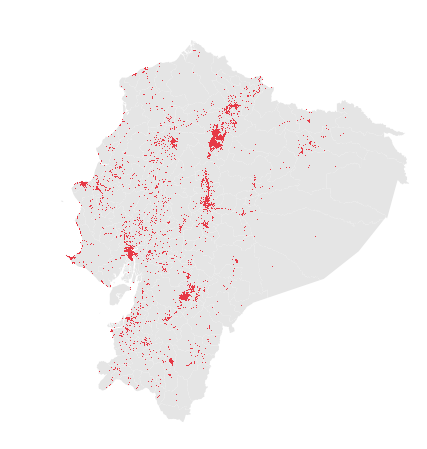

In [35]:
# Map
fig, ax = plt.subplots(1, figsize = (20, 8))
adm2_  .plot(ax = ax, color = "#e5e5e5")
#mobile_.plot(ax = ax, color = "#e63946")
fixed_ .plot(ax = ax, color = "#e63946")
ax.set_xlim(-82,-75)
ax.axis("off")
fig.show()

### 3.2. Administrative level 2

#### Mobile

In [111]:
# Calculate master dataset
adm_mobile = mobile_.copy()
adm_mobile = adm_mobile[[f"ADM2_PCODE","avg_d_mbps","avg_u_mbps","tests"]]
adm_mobile = calculate_stats(adm_mobile, [f"ADM2_PCODE"])
adm_mobile = adm_mobile.drop(columns = "tests")
adm_mobile = adm2.merge(adm_mobile, on = f"ADM2_PCODE", how = "left")

# Export data
adm_mobile.to_csv(f"../data/3-connectivity/mobile_connectivity_adm2.csv")    

In [36]:
# Import data 
adm_mobile = pd.read_csv(f"../data/3-connectivity/mobile_connectivity_adm2.csv")

# Transform to geodata 
adm_mobile['geometry'] = adm_mobile['geometry'].apply(wkt.loads)
adm_mobile = gpd.GeoDataFrame(adm_mobile, crs = 'epsg:4326')

# Select country of interest
adm_mobile = adm_mobile[adm_mobile.ADM0_PCODE == "ECU"]

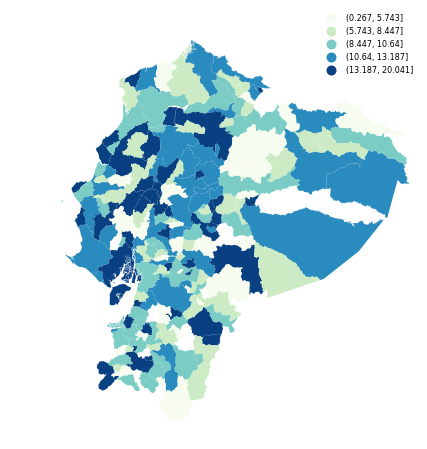

In [39]:
# Map
adm_mobile['group'] = pd.qcut(adm_mobile["avg_u_mbps_wt"], 5)
fig, ax = plt.subplots(1, figsize = (20, 8))
adm_mobile.plot(column = "group", cmap = "GnBu", legend = True, ax = ax, legend_kwds = {'fontsize':8,'frameon':False})
ax.axis('off')
ax.set_xlim(-82,-75)
fig.show()

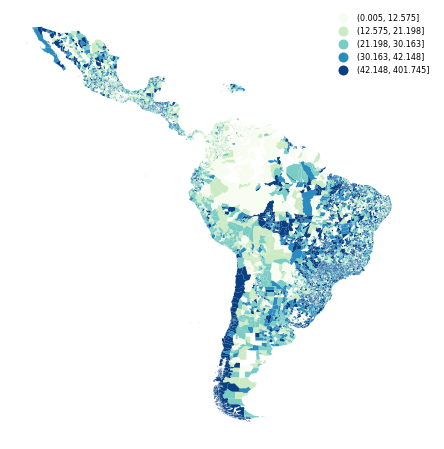

In [112]:
# Map
adm_mobile['group'] = pd.qcut(adm_mobile["avg_d_mbps_wt"], 5)
fig, ax = plt.subplots(1, figsize = (20, 8))
adm_mobile.plot(column = "group", cmap = "GnBu", legend = True, ax = ax, legend_kwds = {'fontsize':8,'frameon':False})
ax.axis('off')
fig.show()

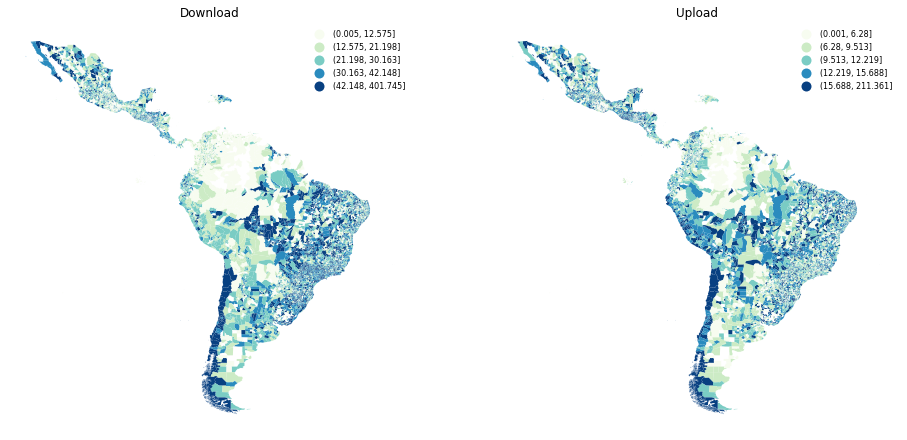

In [132]:
# Create cuts based on quintiles
adm_mobile['group_d'] = pd.qcut(adm_mobile["avg_d_mbps_wt"], 5)
adm_mobile['group_u'] = pd.qcut(adm_mobile["avg_u_mbps_wt"], 5)

# Map
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (16, 8))
adm_mobile.plot(column = "group_d", ax = ax1, cmap = "GnBu", legend = True, legend_kwds = {'fontsize':8,'frameon':False})
adm_mobile.plot(column = "group_u", ax = ax2, cmap = "GnBu", legend = True, legend_kwds = {'fontsize':8,'frameon':False})
ax1.set_title("Download")
ax2.set_title("Upload")
ax1.axis("off")
ax2.axis("off")
fig.show()

#### Fixed

In [122]:
# Calculate master dataset
adm_fixed = fixed_.copy()
adm_fixed = adm_fixed[[f"ADM2_PCODE","avg_d_mbps","avg_u_mbps","tests"]]
adm_fixed = calculate_stats(adm_fixed, [f"ADM2_PCODE"])
adm_fixed = adm_fixed.drop(columns = "tests")
adm_fixed = adm2.merge(adm_fixed, on = f"ADM2_PCODE", how = "left")

# Export data
adm_fixed.to_csv(f"../data/3-connectivity/fixed_connectivity_adm2.csv")     

In [42]:
# Import data 
adm_fixed = pd.read_csv(f"../data/3-connectivity/fixed_connectivity_adm2.csv")

# Transform to geodata 
adm_fixed['geometry'] = adm_fixed['geometry'].apply(wkt.loads)
adm_fixed = gpd.GeoDataFrame(adm_fixed, crs = 'epsg:4326')

# Select country of interest
adm_fixed = adm_fixed[adm_fixed.ADM0_PCODE == "ECU"]

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/geopandas/geodataframe.py:1322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


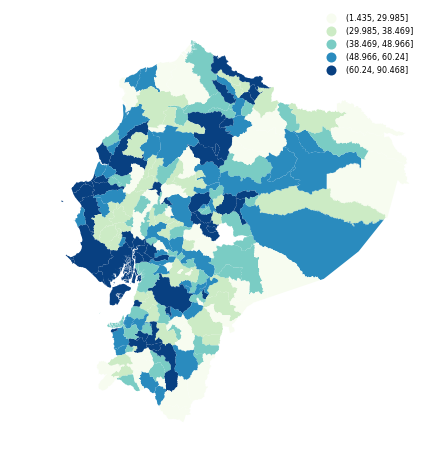

In [47]:
# Map 
adm_fixed['group'] = pd.qcut(adm_fixed["avg_u_mbps_wt"], 5)
fig, ax = plt.subplots(1, figsize = (20, 8))
adm_fixed.plot(column = "group", cmap = "GnBu", legend = True, ax = ax, legend_kwds = {'fontsize':8,'frameon':False})
ax.axis('off')
ax.set_xlim(-82,-75)
fig.show()

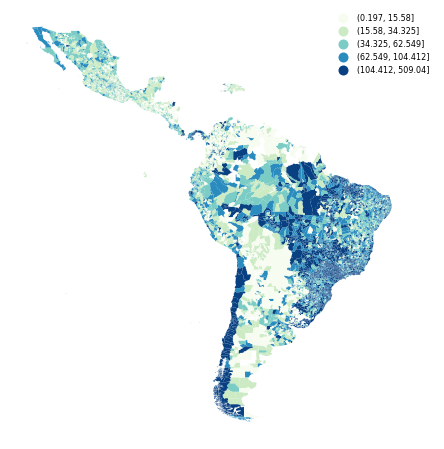

In [99]:
# Map 
adm_fixed['group'] = pd.qcut(adm_fixed["avg_d_mbps_wt"], 5)
fig, ax = plt.subplots(1, figsize = (20, 8))
adm_fixed.plot(column = "group", cmap = "GnBu", legend = True, ax = ax, legend_kwds = {'fontsize':8,'frameon':False})
ax.axis('off')
fig.show()

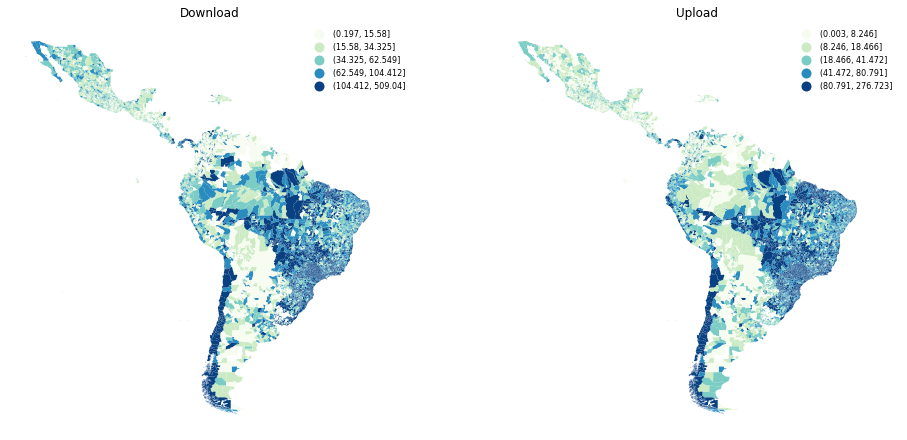

In [133]:
# Create cuts based on quintiles
adm_fixed['group_d'] = pd.qcut(adm_fixed["avg_d_mbps_wt"], 5)
adm_fixed['group_u'] = pd.qcut(adm_fixed["avg_u_mbps_wt"], 5)

# Map
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (16, 8))
adm_fixed.plot(column = "group_d", ax = ax1, cmap = "GnBu", legend = True, legend_kwds = {'fontsize':8,'frameon':False})
adm_fixed.plot(column = "group_u", ax = ax2, cmap = "GnBu", legend = True, legend_kwds = {'fontsize':8,'frameon':False})
ax1.set_title("Download")
ax2.set_title("Upload")
ax1.axis("off")
ax2.axis("off")
fig.show()

## 1. Fixed connectivity

In [4]:
# Fixed connectivity
tile_url = get_tile_url("fixed", 2023, 1)
tile_url

'https://ookla-open-data.s3-us-west-2.amazonaws.com/shapefiles/performance/type%3Dfixed/year%3D2023/quarter%3D1/2023-01-01_performance_fixed_tiles.zip'

In [5]:
tiles = gpd.read_file(tile_url)

#### 1.1 Get boundaries 

In [7]:
# Read shapefiles for ADMIN-1 and ADMIN-2 from the datalake
# You will need the .env to do this
lac_01 = gpd.read_file(scldatalake + "Geospatial Basemaps/Cartographic Boundary Files/LAC-26/region/level-1/lac-level-1.shp")
lac_02 = gpd.read_file(scldatalake + "Geospatial Basemaps/Cartographic Boundary Files/LAC-26/region/level-2/lac-level-2.shp")

#### 1.2 Join boundaries and tiles

In [8]:
# Join tiles with ADMIN-1 and ADMIN-2 shapefiles
# This takes approximately 10 minutes to run. 
tiles_in_lac_01 = gpd.sjoin(tiles, lac_01, how="inner", op= 'intersects')

In [20]:
tiles_in_lac_02 = gpd.sjoin(tiles, lac_02, how="inner", op= 'intersects')

In [9]:
# Convert to Mbps for easier reading
for df in [tiles_in_lac_01]:
    df['avg_d_mbps'] = df['avg_d_kbps'] / 1000
    df['avg_u_mbps'] = df['avg_u_kbps'] / 1000

In [16]:
# Calculate statistics for ADMIN-1 and ADMIN-2
region_stats_01 = calculate_stats(tiles_in_lac_01, ["ADM1_PCODE", "ADM1_EN", "ADM0_PCODE"])
#region_stats_02 = calculate_stats(tiles_in_lac_02, ["ADM2_PCODE", "ADM2_EN","ADM1_PCODE", "ADM1_EN", "ADM0_PCODE"])

In [ ]:
# Save in datalake
region_stats_01.to_csv(scldatalake + "Geospatial Basemaps/Connectivity/fixed/tiles_fixed_LAC_01.csv", index=False)
region_stats_02.to_csv(scldatalake + "Geospatial Basemaps/Connectivity/fixed/tiles_fixed_LAC_02.csv", index=False)

#### Map ADMIN-1 

In [17]:
state_data = lac_01[['ADM1_EN','geometry']].merge(region_stats_01, on ='ADM1_EN').to_crs(26916)

In [18]:
# Generate labels and ranges for plot

labels = ["0 to 25 Mbps", "25 to 50 Mbps", "50 to 100 Mbps", "100 to 150 Mbps", "150 to 200 Mbps"]

state_data['group'] = pd.cut(
    state_data.avg_d_mbps_wt, 
    (0, 25, 50, 100, 150, 200), 
    right=False, 
    labels = labels
)

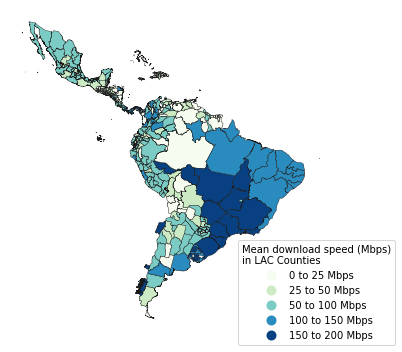

In [19]:
#plot admin level 1

fig, ax = plt.subplots(1, figsize=(9, 6))

state_data.plot(
    column="group", cmap="GnBu", linewidth=0.4, ax=ax, edgecolor="0.1", legend=True
)

ax.axis("off")

leg = ax.get_legend()
leg.set_bbox_to_anchor((1.2, 0.3))
leg.set_title("Mean download speed (Mbps)\nin LAC Counties")

#save picture
fig.savefig("Outputs/speed_lac_state.jpg")

#### Map ADMIN-2

In [14]:
municipality_data = lac_02[['ADM2_EN','geometry']].merge(region_stats_02, on ='ADM2_EN').to_crs(26916)

In [15]:
municipality_data = lac_02[['ADM2_EN','geometry']].merge(region_stats_02, on ='ADM2_EN').to_crs(26916)

# Generate labels and ranges for plot

labels = ["0 to 10 Mbps", "10 to 30 Mbps", "30 to 50 Mbps", "50 to 100 Mbps", "100 to 150 Mbps", "150 to 200 Mbps"]

municipality_data['group'] = pd.cut(
    municipality_data.avg_d_mbps_wt, 
    (0, 10, 30 ,50, 100, 150, 200), 
    right=False, 
    labels = labels
)

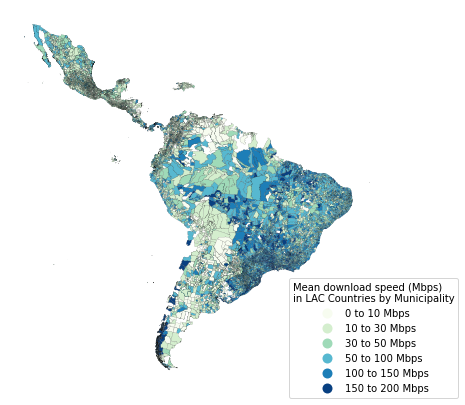

In [16]:
# Generate plot admin level-2

fig_municipality, ax = plt.subplots(1, figsize=(10, 7))

municipality_data.plot(
    column="group", cmap="GnBu", linewidth=0.1, ax=ax, edgecolor="0.1", legend=True
)

ax.axis("off")

leg = ax.get_legend()
leg.set_bbox_to_anchor((1.2, 0.3))
leg.set_title("Mean download speed (Mbps)\nin LAC Countries by Municipality")

#save plot
fig_municipality.savefig("Outputs/speed_lac_municipality.jpg")

## Use case BRA - in progress

In [20]:
municipality_data_bra = municipality_data[municipality_data["ADM0_PCODE"]=="BRA"]

In [39]:
municipality_data_bra.to_csv("Outputs/BRA_conectividad.csv", index = False)

In [22]:
labels = ["0 to 10 Mbps", "10 to 30 Mbps", "30 to 50 Mbps", "50 to 100 Mbps", "100 to 150 Mbps", "150 to 200 Mbps"]

municipality_data_bra['group'] = pd.cut(
    municipality_data_bra.avg_d_mbps_wt, 
    (0, 10, 30 ,50, 100, 150, 200), 
    right=False, 
    labels = labels
)

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/geopandas/geodataframe.py:1322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


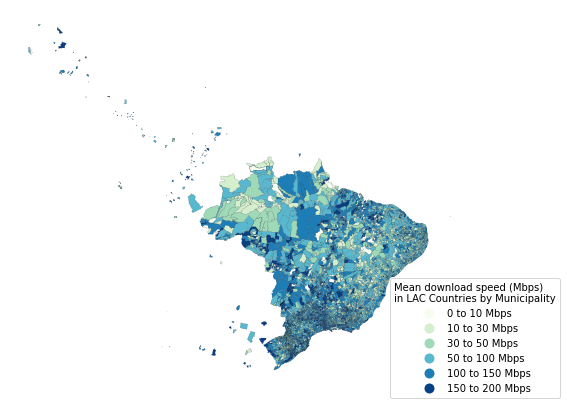

In [23]:
fig_municipality_bra, ax = plt.subplots(1, figsize=(10, 7))

municipality_data_bra.plot(
    column="group", cmap="GnBu", linewidth=0.1, ax=ax, edgecolor="0.1", legend=True
)

ax.axis("off")

leg = ax.get_legend()
leg.set_bbox_to_anchor((1.2, 0.3))
leg.set_title("Mean download speed (Mbps)\nin LAC Countries by Municipality")

fig_municipality_bra.savefig("Outputs/valocidad_bra_MUN.jpg")